In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict, oemolprop
import oenotebook as oenb
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Import output dataframe of XlogP_and_mw_filter.ipynb
df_mw= pd.read_csv("df_mw.csv")
df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like


## 3. Filtering based on number of rotatable bonds

In [3]:
# Number of non-terminal rotatable bonds (excluding -OH)

df_mw["N_Rot"]=None

for i, row in enumerate(df_mw.iterrows()):
    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smiles)
    
    rotcounts = []
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1
    
    del mol
    number_of_rotatable_bonds = len(rotcounts) - 1
    #print ("Max rotors:", number_of_rotatable_bonds)
    #print(df_mw.loc[i,"eMolecules ID"])
    
    df_mw.loc[i,"N_Rot"]= number_of_rotatable_bonds 

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5


In [4]:
# Number of rotatable bonds in fragment-like group shoud be <= 8
df_drug = df_mw.loc[df_mw["group"] == "drug-like"]
df_drug_nrot_interval = df_drug.loc[df_drug["N_Rot"] <= 8]

print("Number of compounds suitable for drug-like group: ", df_drug_nrot_interval.shape[0])

Number of compounds suitable for drug-like group:  23


## 4. Filtering based on possible UV-chromophores

In [5]:
# For UV-metric pKa measurement UV chromophores absorbing in 200-400 nm are necessary.
# I will use presence of C=C-C=C, C=C-C=O or C=C-C=N  substructures as an indictato of UV-chromophore
# 1.3-butadiene absorbs at 217 nm

df_mw["N_UV_chrom"]=None

UV_chromophore_SMARTS = "[n,o,c][c,n,o]cc"

for i, row in enumerate(df_mw.iterrows()):

    # Count number UV absorbing conjugated-pi systems using SMARTS matching

    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))

    #create a substructure search object
    queried_substructure = UV_chromophore_SMARTS
    ss = oechem.OESubSearch(queried_substructure)
    oechem.OEPrepareSearch(mol, ss)

    # loop over matches to count
    matched_ss_list=[]
    UV_chromophore_count = 0
    for index, match in enumerate(ss.Match(mol)):
        if ss.SingleMatch(mol) == True:
            matched_ss_list.append((index, match))
            UV_chromophore_count = len(matched_ss_list)
    
    df_mw.loc[i, "N_UV_chrom"] = UV_chromophore_count

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1,15
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3,41
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2,9
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2,24
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5,24


In [6]:
df_drug = df_mw.loc[df_mw["group"] == "drug-like"].reindex().reset_index(drop=True)
print("Number of compounds suitable for drug-like group: ", df_drug.shape[0])

# What is the minimum number of UV-chromophore matches in the drug-like and fragment-like group?
print("Minimum number of UV-chromophore units in drug-like group: ", min(df_drug["N_UV_chrom"]))

Number of compounds suitable for drug-like group:  25
Minimum number of UV-chromophore units in drug-like group:  17


## 5. Eliminate compounds with NaN price or availability

In [7]:
# Eliminate entries without price in drug-like ste
df_drug = df_drug[np.isfinite(df_drug["Price"])].reset_index(drop=True)

# Eliminate entries with availability less than 100 mg
df_drug = df_drug[df_drug["Availability (mg)"] >= 100.0].reset_index(drop=True)
print("Number of drug-like molecules with price and 100 mg availability:",df_drug.shape[0])

Number of drug-like molecules with price and 100 mg availability: 21


## 6. Sort molecules by their price

In [8]:
df_drug = df_drug.sort_values(by = "Price", ascending = True, inplace=False).reset_index(drop=True)

## 7. Eliminate compounds determined to have experimental logP reported

I run cycles of selecting 10 compounds for drug-like group and checking which ones have experimental logPs reported. eMolecules IDs of compounds with reported logPs were saved in a list, so that we can avoid them.

In [9]:
# Construct a list of eMolecule IDs to avoid because of reported experimental logPs
exp_logP_list = []

# Molecules with logP found in DrugBank
exp_logP_list.append(876432) # gefinitib
exp_logP_list.append(532754) # geninstein
exp_logP_list.append(901601) # celecoxib
exp_logP_list.append(23296409) # sunitinib

# List of molecules with experimental logPs reported in Chemspider
list_of_paths_to_exp_logP_file =  [
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/drugs_with_exp_logP_round1.pickle",
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/drugs_with_exp_logP_round2.pickle"]

print("Number of molecules before filtering by experimental logP:, ",df_drug.shape[0])

for file in list_of_paths_to_exp_logP_file:
    exp_logP_list_chemspider = pickle.load(open(file, "rb"))
    
    for eMol_id in exp_logP_list_chemspider:
        exp_logP_list.append(eMol_id)
    
for eMol_id in exp_logP_list:
        print(eMol_id)
        df_drug = df_drug[df_drug["eMolecules ID"] != eMol_id].reset_index(drop=True)

print("Number of molecules after eliminating compounds with experimental logP: ",df_drug.shape[0])

Number of molecules before filtering by experimental logP:,  21
876432
532754
901601
23296409
4424334
17664146
2010194
Number of molecules after eliminating compounds with experimental logP:  15


## 8. Exclude compounds with unwanted chemical group
We decided to eliminate compounds that have iodine groups.

In [10]:
smarts_to_exclude={}
# smarts_to_exclude={'iodine':'I'}

## 9. Include molecules with ring scaffolds of FDA approved PKIs
Murcko fragments of FDA approved Protein Kinase Inhibitors were created. I analyzed the frequency of appearance of ring fragments. The following rings were seen multiple times:
1. pyridine
2. piperazine
3. quinazoline
4. quinoline
5. pyrimidine
6. indazole
7. pyrazole
8. imidazole

I attempt to find drug-like molecules with the same scaffolds.

In [11]:
ring_smarts = {'pyridine':"c1cccc[nX2]1",
               'piperazine': "[NX3]1CC[NX3]CC1",
               'quinazoline': "c:1:c:2:c(:c:c:c:1):n:c:n:c:2",
               'quinoline': "c:1:c:2:c(:c:c:c:1):n:c:c:c:2",
               'pyrimidine': "c1[nX2]ccc[nX2]1",
               'indazole': "c1c2c(ccc1)nnc2",
               'pyrazole': "c1cnnc1",
               'imidazole': "c1nccn1"}

#How to record selected compounds
picked_ids=[]
df_drug["Selection"] = None
df_drug["Bin index"] = None
df_drug["Priority"] = None
df_drug["Final list"] = False

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_drug.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Skip molecule if it has an excluded group 
        # substructure search
        ex_count = 0
        for ex_group, ex_smarts in smarts_to_exclude.items():      
            mol = oechem.OEGraphMol()
            oechem.OESmilesToMol(mol, str(smiles))

            ss = oechem.OESubSearch(ex_smarts)
            oechem.OEPrepareSearch(mol, ss)

            # loop over matches to count
            matched_ss_list=[]
            for index, match in enumerate(ss.Match(mol)):
                if ss.SingleMatch(mol) == True:
                    matched_ss_list.append((index, match))
                    ex_count = ex_count + len(matched_ss_list)
        if ex_count >= 1:
            # print("Skipping molecule with excluded structure: ",smiles, i)
            continue
                
        # Substructure search for desired ring structure
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)

        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_drug.loc[i, "Selection"] != "picked"):
            df_drug.loc[i,"Selection"] = "picked"
            df_drug.loc[i,"Priority"] = 1
            df_drug.loc[i,"Final list"] = True 
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))

Molecule that has pyrazole: CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl
Could not found a molecule that has piperazine!
Molecule that has quinoline: c1cc2c(cc(c(c2nc1)O)I)I
Could not found a molecule that has imidazole!
Molecule that has quinazoline: c1ccc2c(c1)c(=O)[nH]c(n2)CCC(=O)Nc3ncc(s3)Cc4ccc(c(c4)F)F
Could not found a molecule that has pyridine!
Molecule that has pyrimidine: COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO
Could not found a molecule that has indazole!


In [12]:
df_drug_picked = df_drug[df_drug["Selection"]=="picked"].reset_index(drop=True)
df_drug_picked

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom,Selection,Bin index,Priority,Final list
0,10794751,CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl,O=C(Nc1cccc(c1Cl)Cl)Nc1cc(nn1c1ccccc1)C(C)(C)C,[4.113],5.784,403.305,324.5,148.0,drug-like,6,35,picked,None,1,True
1,1415746,COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO,OCCNc1ncnc2c1c(c1ccc(cc1)OC)c(o2)c1ccc(cc1)OC,[4.829],2.794,391.420,398.0,168.0,drug-like,7,71,picked,None,1,True
2,536848,c1cc2c(cc(c(c2nc1)O)I)I,Ic1cc(I)c2c(c1O)nccc2,"[3.511, 6.794]",3.371,396.951,239.0,168.0,drug-like,0,29,picked,None,1,True
3,18897105,c1ccc2c(c1)c(=O)[nH]c(n2)CCC(=O)Nc3ncc(s3)Cc4c...,O=C(Nc1ncc(s1)Cc1ccc(c(c1)F)F)CCc1nc2ccccc2c(=...,"[9.381, 10.773]",3.341,426.439,247.7,223.0,drug-like,7,37,picked,None,1,True


(0, 10)

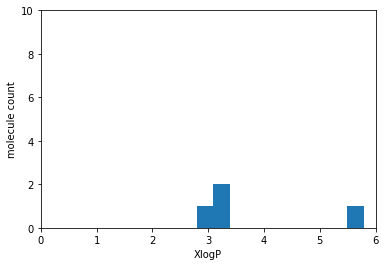

In [13]:
# Let's check the logP distribution of drug-like group
XlogP_values = df_drug_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

## 10. Limit frequently appearing rings

### Limit multiple compounds with aminothiozole group
Aminothiozole group could be reactive and it is uncommon in medicinal screening libraries. Without this filter they showed up too frequenty in my fragment and drug sets. I will include only 1 molecule with 2-aminothiazole group.

### Limit the other frequent groups
1. thiophene
2. 5-methylenethiazolidine-2,4-dione
3. 1,3,4-thiadiazole

Without this filter they showed up too frequenty in my fragment and drug sets. 
I will select one compound from these groups and eliminate replicates.

In [14]:
ring_smarts_to_limit = {
               'aminothiazole': "[c,C]~1(~[nX2,NX2]~[c,C]~[c,C]~[s,S]~1)[NX3,nX3]",
               'thiophene': "c1cscc1",
               '5-methylenethiazolidine-2,4-dione': "[NX3,nX3]1[c,C]([s,S][c,C]([c,C]1=[O,o])=[C,c])=[O,o]",
               '1,3,4-thiadiazole': "n1:csc:n1"}

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts_to_limit.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_drug.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Skip molecule if it has an excluded group 
        # substructure search
        ex_count = 0
        for ex_group, ex_smarts in smarts_to_exclude.items():      
            mol = oechem.OEGraphMol()
            oechem.OESmilesToMol(mol, str(smiles))

            ss = oechem.OESubSearch(ex_smarts)
            oechem.OEPrepareSearch(mol, ss)

            # loop over matches to count
            matched_ss_list=[]
            for index, match in enumerate(ss.Match(mol)):
                if ss.SingleMatch(mol) == True:
                    matched_ss_list.append((index, match))
                    ex_count = ex_count + len(matched_ss_list)
            
        if ex_count >= 1:
            continue
        
        # Substructure search for limited ring group
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)
        
        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_drug.loc[i, "Selection"] != "picked"):
            df_drug.loc[i,"Selection"] = "picked"
            df_drug.loc[i,"Priority"] = 1
            df_drug.loc[i,"Final list"] = True
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))
 

Molecule that has 5-methylenethiazolidine-2,4-dione: c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3
Molecule that has 1,3,4-thiadiazole: c1ccc(c(c1)C(=O)Nc2nnc(s2)SCc3ccc(cc3)Br)Cl
Molecule that has aminothiazole: CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl
Molecule that has thiophene: c1ccc(cc1)C(=O)Nc2ccc(cc2)Oc3c4c5c(sc4ncn3)CCCC5


In [15]:
df_drug_picked = df_drug[df_drug["Selection"]=="picked"].reset_index(drop=True)
df_drug_picked

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom,Selection,Bin index,Priority,Final list
0,3365457,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc1ccc(c(c1)Cl)Cl,[9.167],5.171,381.276,489.9,148.0,drug-like,6,28,picked,None,1,True
1,10794751,CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl,O=C(Nc1cccc(c1Cl)Cl)Nc1cc(nn1c1ccccc1)C(C)(C)C,[4.113],5.784,403.305,324.5,148.0,drug-like,6,35,picked,None,1,True
2,1415746,COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO,OCCNc1ncnc2c1c(c1ccc(cc1)OC)c(o2)c1ccc(cc1)OC,[4.829],2.794,391.420,398.0,168.0,drug-like,7,71,picked,None,1,True
3,536848,c1cc2c(cc(c(c2nc1)O)I)I,Ic1cc(I)c2c(c1O)nccc2,"[3.511, 6.794]",3.371,396.951,239.0,168.0,drug-like,0,29,picked,None,1,True
4,46568819,c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3,O=C1NC(=O)/C(=C\c2cccc(c2)OCc2ccc(cc2Cl)Cl)/S1,[8.05],5.238,380.245,154.0,219.0,drug-like,4,24,picked,None,1,True
5,18897105,c1ccc2c(c1)c(=O)[nH]c(n2)CCC(=O)Nc3ncc(s3)Cc4c...,O=C(Nc1ncc(s1)Cc1ccc(c(c1)F)F)CCc1nc2ccccc2c(=...,"[9.381, 10.773]",3.341,426.439,247.7,223.0,drug-like,7,37,picked,None,1,True
6,3064762,c1ccc(cc1)C(=O)Nc2ccc(cc2)Oc3c4c5c(sc4ncn3)CCCC5,O=C(c1ccccc1)Nc1ccc(cc1)Oc1ncnc2c1c1CCCCc1s2,[3.199],4.718,401.481,636.9,249.0,drug-like,5,34,picked,None,1,True
7,5428718,c1ccc(c(c1)C(=O)Nc2nnc(s2)SCc3ccc(cc3)Br)Cl,Brc1ccc(cc1)CSc1nnc(s1)NC(=O)c1ccccc1Cl,[6.525],5.900,440.765,239.5,400.0,drug-like,6,24,picked,None,1,True


(0, 10)

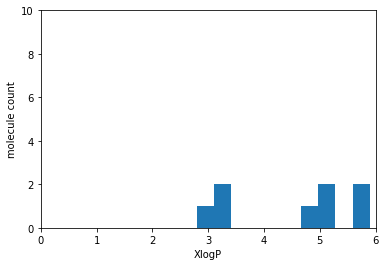

In [16]:
# Let's check the logP distribution of drug-like group
XlogP_values = df_drug_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [17]:
# Import database as eonb for visualization
#drug_picked_smiles = df_drug_picked.loc[:,"canonical isomeric SMILES"].tolist()

#file_name = "drug_picked.smi"
#writer = open(file_name, "w")

#for smiles in drug_picked_smiles:
#    writer.write("%s\n" %smiles)

#df_drug_picked_oenb = oenb.read_file_to_dataframe(filename="drug_picked.smi")
#oenb.render_dataframe(df_drug_picked_oenb, width=200, height=200)

Replace unwanted compounds:
- compound with iodines (eMolecules ID : 536848, SMILES="c1cc2c(cc(c(c2nc1)O)I)I") with another quinoline
- compound with bromine (eMolecules ID: 17664146, SMILES = "CN1CCN(CC1)c2c(cccc2Cl)NC(=O)c3ccc(o3)Br" with another piperazine)
- compound with titratable group too far from chromophore (eMolecules ID = 4038159, SMILES = "Cc1ccc(cc1C)c2csc(c2C(=O)N)NC(=O)CCCC(=O)O)") with another quanizoline

In [18]:
# Drop unwanted compounds
#unwanted_eMol_IDs = [536848, 17664146, 4038159]
#for eMol_ID in unwanted_eMol_IDs:
#    df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Selection"] = None
#    df_drug.loc[df_drug["eMolecules ID"] == eMol_ID, "Selection"] == None
#
#df_drug_picked = df_drug_picked.loc[df_drug_picked["Selection"] == "picked"].reset_index(drop=True)
#print("Number of selected fragment-like molecules after removing unwanted molecules:",df_drug_picked.shape[0])

# Pick replacement compounds with quinoline and piperazine?

In [19]:
# Let's check the logP distribution of drug-like group
#XlogP_values = df_drug_picked.loc[:, "XlogP"]
#plt.hist(XlogP_values, bins=10)
#plt.xlabel("XlogP")
#plt.ylabel("molecule count")
#plt.xlim(0,6)
#plt.ylim(0,10)

## 11. Select molecules for even coverage of logP dynamic range

While selecting from each logP bin, first compounds selected for their ring substructres will be assigned to each bin. Then for selecting more compounds I will prioritize cheaper compounds, based on the price sorted dataframes.

10 drug-like molecules will be selected.

In [20]:
# Establish dynamic range
XlogPs = np.array(df_drug["XlogP"])

minval = XlogPs.min()
maxval = XlogPs.max()

#print("Dynamic range of XlogP is from %.2f to %.2f" % (minval, maxval))

# Let's make 5 bins and try drawing for 3 compounds per bin
nbins = 5
n_per_bin = 3 
bin_lefts = np.arange( minval, maxval, (maxval-minval)/float(nbins) )
bin_rights = np.array( [bin_lefts[i+1] for i in range(nbins-1)] + [maxval] )

print("Bin lefts: \n", bin_lefts)
print("Bin rights: \n", bin_rights)

# Place compounds selected for their substructures to correponding bins
range_ids = []
fnd_in_bin = 0
for i, row in df_drug.iterrows():
    
    # Iterate over selected compounds
    if df_drug.loc[i, "Selection"] == "picked":
        eMolecules_ID = df_drug.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_drug.loc[i,'XlogP'])
        
        # iterate over bins to find the right bin
        for bin_index in range(nbins):
            # how many compounds are in that bin so far?
            fnd_in_bin = df_drug.loc[df_drug["Bin index"]== bin_index].shape[0]
            
            if (XlogP > bin_lefts[bin_index]) and (XlogP <= bin_rights[bin_index]):
                range_ids.append( eMolecules_ID )
                fnd_in_bin +=1
                df_drug.loc[i, "Bin index"] = bin_index
                df_drug.loc[i, "Priority"] = fnd_in_bin
                print("Molecule {} is already selected from bin {}.".format(eMolecules_ID, bin_index))

print("Selecting more compounds from each bin...")

# Select compounds from each bin
for bin_index in range(nbins):
    
    # how many compounds are in that bin so far?
    fnd_in_bin = df_drug.loc[df_drug["Bin index"]== bin_index].shape[0]
    
    for i, row in enumerate(df_drug.iterrows()):
        eMolecules_ID = df_drug.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_drug.loc[i,'XlogP'])
        
        if (XlogP > bin_lefts[bin_index]) and (XlogP <= bin_rights[bin_index]) and (df_drug.loc[i, "Selection"] != "picked"):
            
            # Skip molecule if it has a limited ring group, because we have already picked one.
            # substructure search
            count = 0
            for ring, smarts in ring_smarts_to_limit.items(): 
            
                smiles = df_drug.loc[i,'canonical isomeric SMILES']
                mol = oechem.OEGraphMol()
                oechem.OESmilesToMol(mol, str(smiles))

                queried_substructure = smarts
                ss = oechem.OESubSearch(queried_substructure)
                oechem.OEPrepareSearch(mol, ss)

                # loop over matches to count
                matched_ss_list=[]
                for index, match in enumerate(ss.Match(mol)):
                    if ss.SingleMatch(mol) == True:
                        matched_ss_list.append((index, match))
                        count = count + len(matched_ss_list)
            # skip the molecule if one of the limited substructes exists in the molecule
            if count >= 1:
                continue
            
            # Skip molecule if it has an excluded group 
            # substructure search
            count = 0
            for group, smarts in smarts_to_exclude.items(): 
            
                smiles = df_drug.loc[i,'canonical isomeric SMILES']
                mol = oechem.OEGraphMol()
                oechem.OESmilesToMol(mol, str(smiles))

                queried_substructure = smarts
                ss = oechem.OESubSearch(queried_substructure)
                oechem.OEPrepareSearch(mol, ss)

                # loop over matches to count
                matched_ss_list=[]
                for index, match in enumerate(ss.Match(mol)):
                    if ss.SingleMatch(mol) == True:
                        matched_ss_list.append((index, match))
                        count = count + len(matched_ss_list)
                    
            # skip the molecule if one of the limited substructes exists in the molecule
            if count >= 1:
                continue
                
            # Pick the compound
            range_ids.append( eMolecules_ID )
            fnd_in_bin +=1
            
            df_drug.loc[i, "Selection"] = "picked"
            df_drug.loc[i, "Bin index"] = bin_index
            df_drug.loc[i, "Priority"] = fnd_in_bin
                

        if fnd_in_bin == n_per_bin: break

    if fnd_in_bin < n_per_bin:
        print ("Can't find %s molecules in bin %s. Only %s molecule(s) found." % (n_per_bin, bin_index, fnd_in_bin) )


print("Found %s compounds spanning the dynamic range, out of %s desired. " % (len(range_ids), nbins*n_per_bin) )

Bin lefts: 
 [ 2.79400039  3.41520033  4.03640027  4.65760021  5.27880015]
Bin rights: 
 [ 3.41520033  4.03640027  4.65760021  5.27880015  5.9000001 ]
Molecule 3365457 is already selected from bin 3.
Molecule 10794751 is already selected from bin 4.
Molecule 536848 is already selected from bin 0.
Molecule 46568819 is already selected from bin 3.
Molecule 18897105 is already selected from bin 0.
Molecule 3064762 is already selected from bin 3.
Molecule 5428718 is already selected from bin 4.
Selecting more compounds from each bin...
Can't find 3 molecules in bin 1. Only 0 molecule(s) found.
Can't find 3 molecules in bin 2. Only 1 molecule(s) found.
Can't find 3 molecules in bin 4. Only 2 molecule(s) found.
Found 9 compounds spanning the dynamic range, out of 15 desired. 


(0, 10)

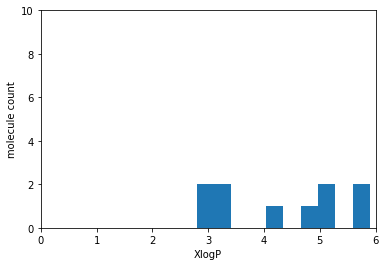

In [21]:
df_drug_picked = df_drug.loc[df_drug["Selection"]=="picked"].reset_index(drop=True)
df_drug_picked.to_csv("df_drug_picked.csv")

# Let's check the logP distribution of drug-like group
XlogP_values = df_drug_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [22]:
df_drug_final = df_drug[df_drug["Final list"] == True]
eMol_id_in_final_list = list(df_drug_final["eMolecules ID"])
print(eMol_id_in_final_list)

[3365457, 10794751, 1415746, 536848, 46568819, 18897105, 3064762, 5428718]


In [23]:
# Construct the final list

# Sort selected molecules by bin index
df_drug_picked = df_drug_picked.sort_values(by = ["Bin index", "Price"], ascending = [True, True], inplace=False)

# Select 4 cheapest compounds with even bin distribution

#In first pass select the cheapest molecule in each bin
for bin_index in range(nbins):
    print("bin: ", bin_index)
    df_bin = df_drug_picked[df_drug_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if len(eMol_id_in_final_list) >= 10:
        break
    else:

        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] >= 1:
            #select the cheapest unselected molecule
            for i,row in df_bin.iterrows():
                eMol_ID = row["eMolecules ID"]
                if eMol_ID in eMol_id_in_final_list: # skip if molecule was selected before
                    print(eMol_ID, "was selected before, so skipped.")
                    continue 
                else:
                    eMol_id_in_final_list.append(eMol_id) 
                    #print("emol id: ", eMol_ID)
                    df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Final list"] = True


bin:  0
536848 was selected before, so skipped.
18897105 was selected before, so skipped.
bin:  1
bin:  2
bin:  3


(0, 10)

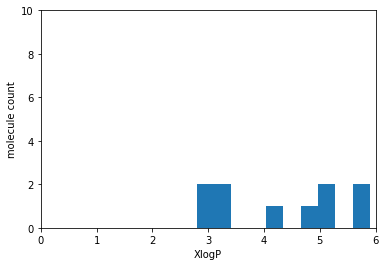

In [24]:
# Let's check the logP distribution of final drug-like group
df_drug_final = df_drug_picked[df_drug_picked["Final list"] == True].reset_index(drop=True)
df_drug_final.to_csv("df_drug_final.csv", index = False)

XlogP_values = df_drug_final.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [25]:
# Calculate cost for drug set
drug_set_cost_100mg = 0

for i, row in enumerate(df_drug_final.iterrows()):
    cost = df_drug_final.loc[i, "Price"]
    #print(cost)
    drug_set_cost_100mg += cost
print("Cost for drug set for 100 mg is {} USD.".format(drug_set_cost_100mg))

Cost for drug set for 100 mg is 2059.0 USD.


,Molecule
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

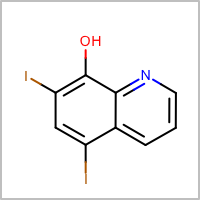
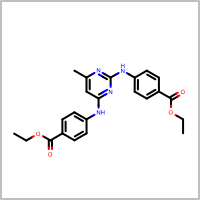
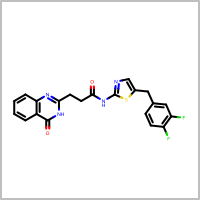
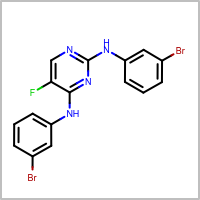
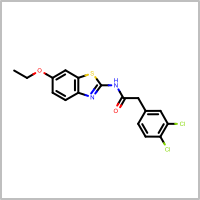
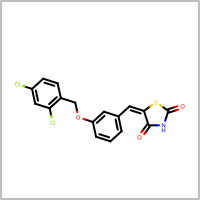
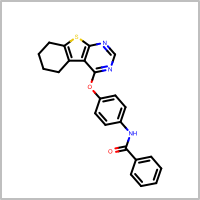
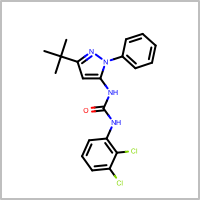
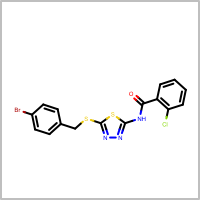
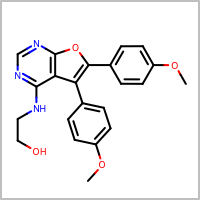

In [29]:
# Import database as eonb for visualization
drug_final_smiles = df_drug_final.loc[:,"canonical isomeric SMILES"].tolist()

file_name = "drug_picked.smi"
writer = open(file_name, "w")

for smiles in drug_final_smiles:
    writer.write("%s\n" %smiles)

df_drug_picked_oenb = oenb.read_file_to_dataframe(filename="drug_picked.smi")
oenb.render_dataframe(df_drug_picked_oenb, width=200, height=200)

In [27]:
df_drug_final

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom,Selection,Bin index,Priority,Final list
0,536848,c1cc2c(cc(c(c2nc1)O)I)I,Ic1cc(I)c2c(c1O)nccc2,"[3.511, 6.794]",3.371,396.951,239.0,168.0,drug-like,0,29,picked,0,1,True
1,4375254,CCOC(=O)c1ccc(cc1)Nc2cc(nc(n2)Nc3ccc(cc3)C(=O)...,CCOC(=O)c1ccc(cc1)Nc1cc(C)nc(n1)Nc1ccc(cc1)C(=...,[6.336],2.937,420.461,319.0,168.0,drug-like,10,28,picked,0,3,True
2,18897105,c1ccc2c(c1)c(=O)[nH]c(n2)CCC(=O)Nc3ncc(s3)Cc4c...,O=C(Nc1ncc(s1)Cc1ccc(c(c1)F)F)CCc1nc2ccccc2c(=...,"[9.381, 10.773]",3.341,426.439,247.7,223.0,drug-like,7,37,picked,0,2,True
3,1574612,c1cc(cc(c1)Br)Nc2c(cnc(n2)Nc3cccc(c3)Br)F,Brc1cccc(c1)Nc1ncc(c(n1)Nc1cccc(c1)Br)F,[3.892],4.140,438.092,222.0,168.0,drug-like,4,28,picked,2,1,True
4,3365457,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc1ccc(c(c1)Cl)Cl,[9.167],5.171,381.276,489.9,148.0,drug-like,6,28,picked,3,1,True
5,46568819,c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3,O=C1NC(=O)/C(=C\c2cccc(c2)OCc2ccc(cc2Cl)Cl)/S1,[8.05],5.238,380.245,154.0,219.0,drug-like,4,24,picked,3,2,True
6,3064762,c1ccc(cc1)C(=O)Nc2ccc(cc2)Oc3c4c5c(sc4ncn3)CCCC5,O=C(c1ccccc1)Nc1ccc(cc1)Oc1ncnc2c1c1CCCCc1s2,[3.199],4.718,401.481,636.9,249.0,drug-like,5,34,picked,3,3,True
7,10794751,CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl,O=C(Nc1cccc(c1Cl)Cl)Nc1cc(nn1c1ccccc1)C(C)(C)C,[4.113],5.784,403.305,324.5,148.0,drug-like,6,35,picked,4,1,True
8,5428718,c1ccc(c(c1)C(=O)Nc2nnc(s2)SCc3ccc(cc3)Br)Cl,Brc1ccc(cc1)CSc1nnc(s1)NC(=O)c1ccccc1Cl,[6.525],5.900,440.765,239.5,400.0,drug-like,6,24,picked,4,2,True
9,1415746,COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO,OCCNc1ncnc2c1c(c1ccc(cc1)OC)c(o2)c1ccc(cc1)OC,[4.829],2.794,391.420,398.0,168.0,drug-like,7,71,picked,None,1,True


In [28]:
df_drug_final.loc[2,"eMolecules SMILES" ]

'O=C(Nc1ncc(s1)Cc1ccc(c(c1)F)F)CCc1nc2ccccc2c(=O)[nH]1'